# 二八轮动


二八轮动，指的是市值最大的前 20% 数量的大盘股和剩下数目占 80% 的中小盘股之间的轮动。经典二八轮动策略的主要驱动逻辑是动量。动量就是资产近期涨幅的横向排名，它与趋势很像，但多了一层横向比较：看谁过去涨得多或跌得少，然后就买谁。

二八轮动假设了市场资金的流动是有惯性的：当近期大盘股涨得多的时候，后续大概率资金还会持续地向大盘股流入；直到这个趋势难以持续下去的时候，资金又会向小盘股流动，而且这个趋势一旦开始，资金就又会一直往小盘股流入。


额外为 matplotlib 加载中文字体

In [1]:
%autosave 0
%run ./shared/tools.py
from shared.tools import set_plot_font

# download font file
font_file = '../../res/MicrosoftYaHei.ttf'
!(FONT_FILE=../../res/MicrosoftYaHei.ttf && [ ! -f ${FONT_FILE} ] \
    && curl "https://raw.githubusercontent.com/hdouhua/ml-in-action/main/res/Microsoft%20YaHei.ttf" -o ${FONT_FILE})

set_plot_font(font_file)

Autosave disabled


策略逻辑

In [2]:
%run ./shared/small_large_cap_rotation.py

from shared.small_large_cap_rotation import RotationType, get_widgets, load_data, run_strategy, backtest_result

加载回测数据


In [3]:
# index_price = pd.read_csv('../res/main-indices-data.csv').set_index('datetime')
# index_price.index = [datestr2dtdate(e) for e in index_price.index]

设置回测参数


In [4]:
ui, datePickers, symbols = get_widgets()
ui

- [消费红利指数 (H30094)](https://www.csindex.com.cn/zh-CN#/indices/family/detail?indexCode=H30094)
- [中证主要消费指数 (000932)](https://www.csindex.com.cn/zh-CN#/indices/family/detail?indexCode=000932)
- [上证主要消费行业指数 (000036)](https://www.csindex.com.cn/zh-CN#/indices/family/detail?indexCode=000036)

In [13]:
params = {'start_date': datePickers[0].value, 'end_date': datePickers[1].value, 'N': datePickers[2].value, 
          'long_spread':0, 'short_spread': 0}
small_index = symbols[0].value
small_is_fund = symbols[1].value
large_index = symbols[2].value
large_is_fund = symbols[3].value

print(f"loading data {small_index} and {large_index}, params: ")
print(f"\tstart : {params['start_date'] }\n\tend   : {params['end_date']}\n\tN     : {params['N']} days")
index_price = load_data(small_index, large_index, small_is_fund, large_is_fund)

loading data 399296 and 000932, params: 
	start : 2020-01-01
	end   : 2022-12-31
	N     : 20 days


下面回测以沪深 300 指数和中证 500 指数为交易标的，其中沪深 300 指数代表大盘股，中证 500 指数代表中小盘股。每天回看这两个指数最近 N 个交易日的涨幅，当沪深 300 的区间涨幅大于中证 500 时，持有沪深 300；当中证 500 的区间涨幅大于沪深 300 时，持有中证 500。

## 二八轮动：满仓版本


         AnnRet    AnnVol        SR     MaxDD    Calmar  TotalRet
small  0.187199  0.320992  0.583191 -0.430946  0.434391  0.675664
large  0.099767  0.266162  0.374835 -0.443272  0.225069  0.331200
stgy   0.271346  0.299289  0.906636 -0.305245  0.888947  1.058986


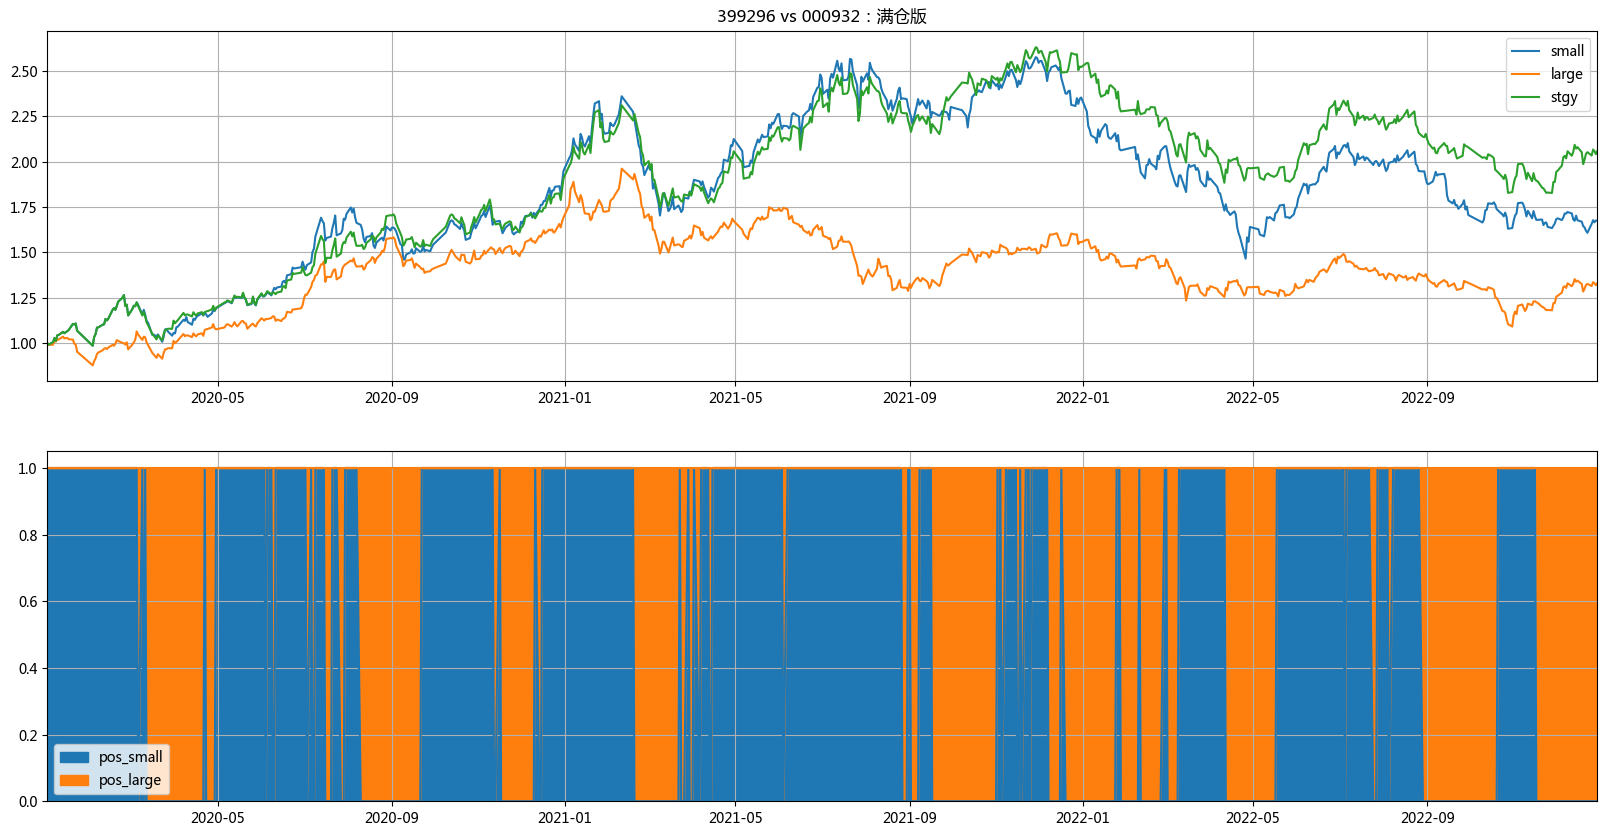

In [14]:
df = run_strategy(index_price, rotation_type=RotationType.FULL, params=params)

backtest_result(df, title=f'{small_index} vs {large_index}：满仓版')

<hr />

## 二八轮动：可空仓版

总是满仓版本的二八轮动虽然性价比很高，但回撤水平仍然不是普通个人投资者能接受的。可以空仓的版本，它与前面版本的唯一差异就是，当回看 N 个交易日涨幅时，如果两个指数均为下跌，就选择空仓。


         AnnRet    AnnVol        SR     MaxDD    Calmar  TotalRet
small  0.187199  0.320992  0.583191 -0.430946  0.434391  0.675664
large  0.099767  0.266162  0.374835 -0.443272  0.225069  0.331200
stgy   0.275736  0.243913  1.130466 -0.193919   1.42191  1.080446


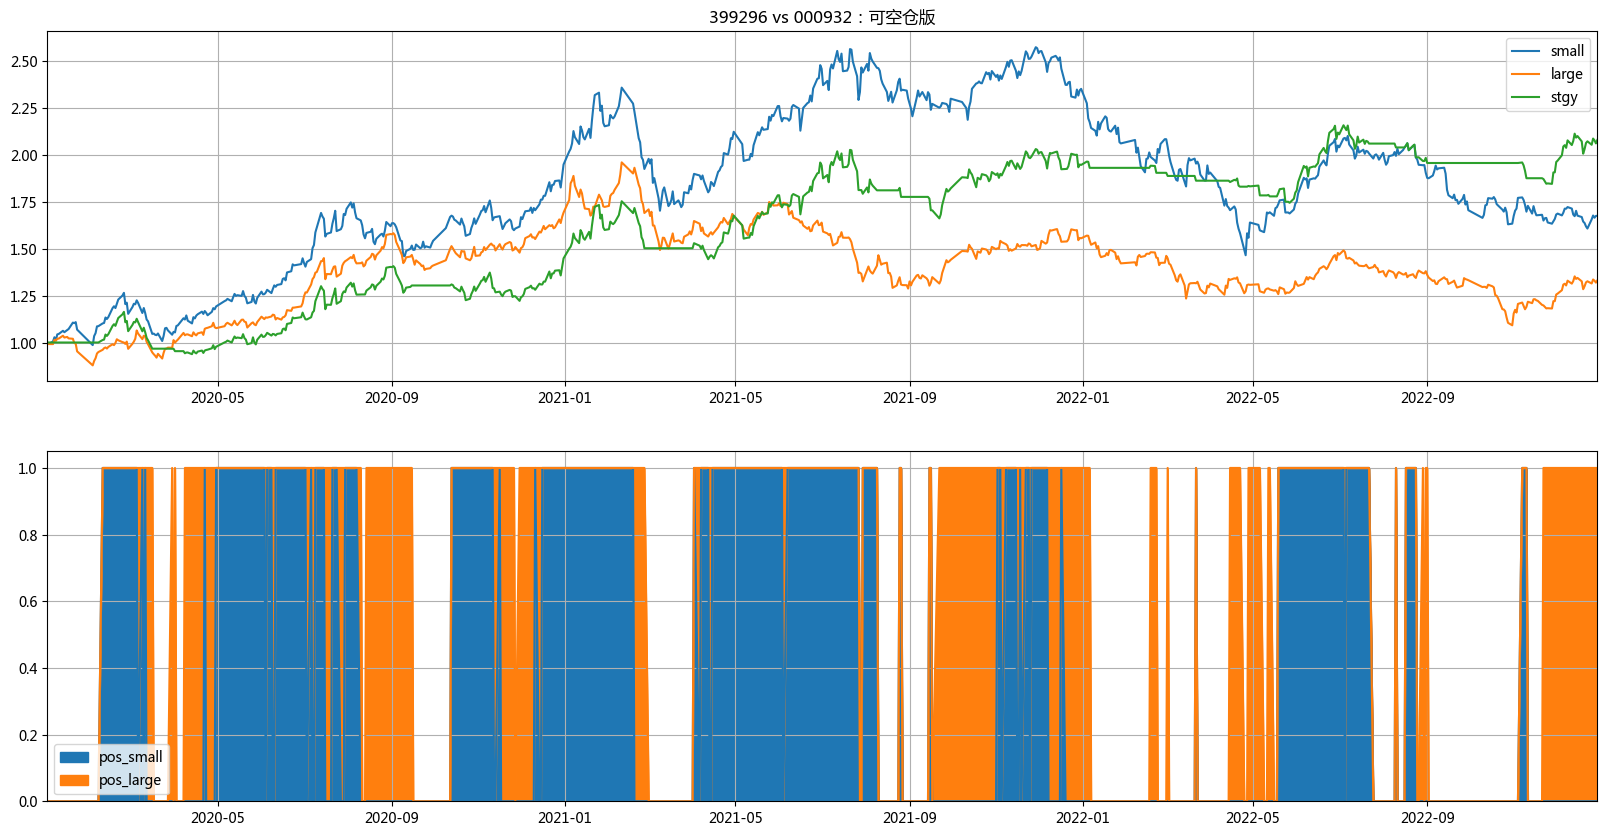

In [15]:
df = run_strategy(index_price, rotation_type=RotationType.NULLABLE, params=params)

backtest_result(df, title=f'{small_index} vs {large_index}：可空仓版')

美中不足：因为策略会空仓，所以 2019 到 2020 两年的慢牛行情中获利不多——这是降低最大回撤的合理代价。

<hr />


## 二八轮动：增强版

——满仓和可空仓结合体，基于股市温度决定使用满仓版还是可空仓版。

股市温度由 沪深 300 收益率 和 十年期国债 比值 T 来衡量:

- T >= 3 : 股市温度低，也就是寒冬，非常有吸引力
- T <= 1.8 : 股市温度很高，大夏天，风险高于回报了，不具有吸引力

[T 值参考](http://www.dashiyetouzi.com/tools/compare/hs300_10gz_pro.php)


         AnnRet    AnnVol        SR     MaxDD    Calmar  TotalRet
small  0.187199  0.320992  0.583191 -0.430946  0.434391  0.675664
large  0.099767  0.266162  0.374835 -0.443272  0.225069  0.331200
stgy   0.362157  0.279898   1.29389 -0.217801  1.662791  1.533906


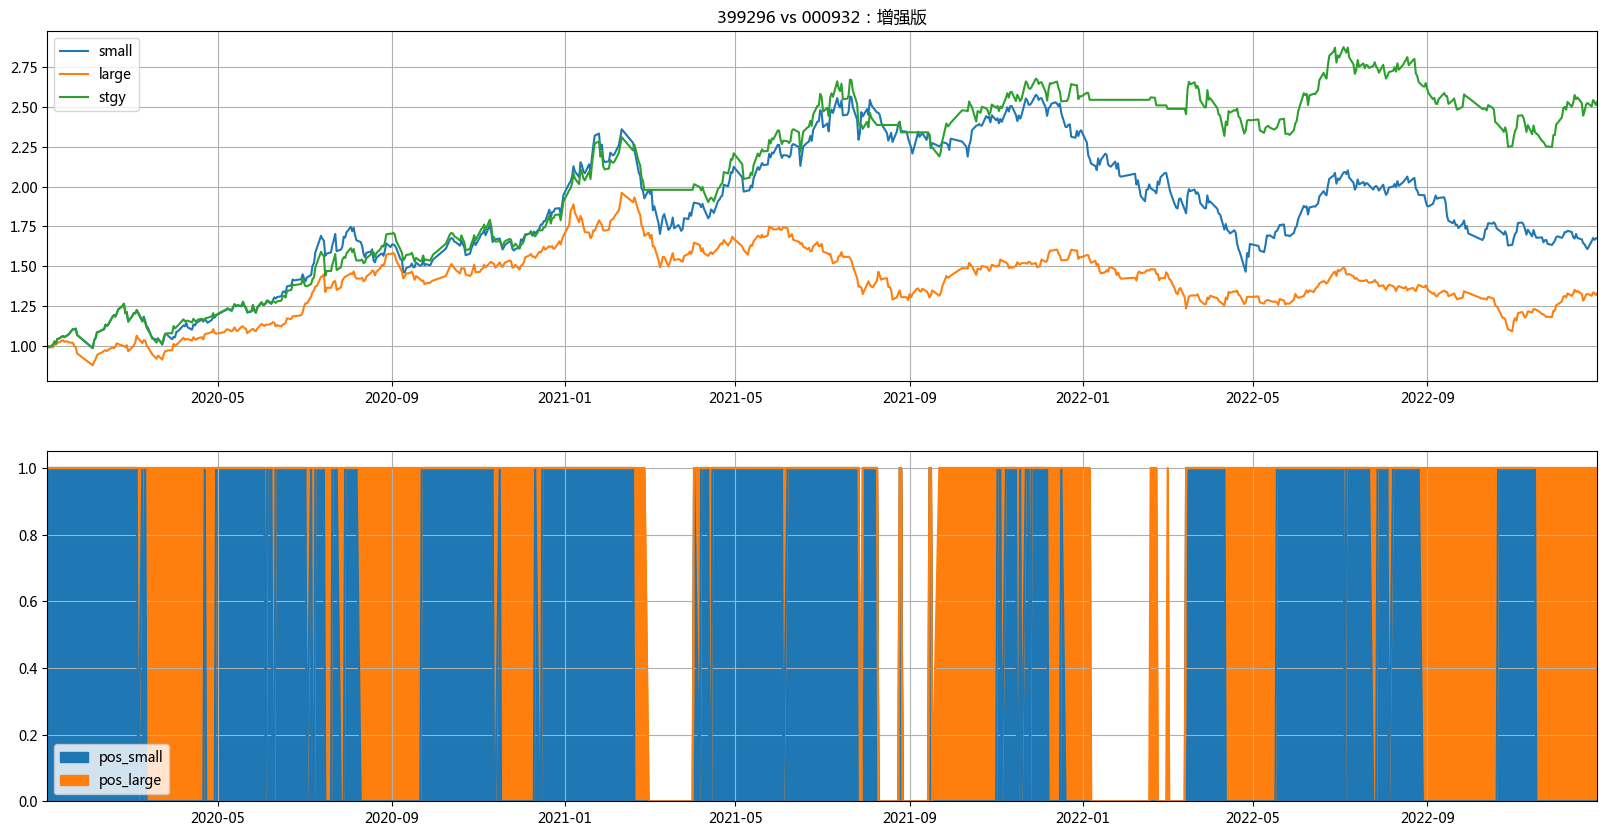

In [16]:
df = run_strategy(index_price, rotation_type=RotationType.ENHANCED, params=params)

backtest_result(df, title=f'{small_index} vs {large_index}：增强版')